In [1]:
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

warnings.filterwarnings('ignore')

In [2]:
# Read data

df = pd.read_csv('/Users/tomas/OneDrive/Pulpit/studia/magister/2 sem/MGR/Mgr/courses/mckay/project2.csv')

In [3]:
df.head()

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee
0,1.0,Fri,2018-08-17,20:15,Girona,0.7,0–0,0.0,Valladolid,10368.0,Estadi Municipal de Montilivi,Guillermo Cuadra
1,1.0,Fri,2018-08-17,22:15,Betis,0.9,0–3,2.5,Levante,46225.0,Estadio Benito Villamarín,Ignacio Iglesias
2,1.0,Sat,2018-08-18,18:15,Celta Vigo,0.6,1–1,0.6,Espanyol,16215.0,Estadio de Balaídos,Santiago Jaime
3,1.0,Sat,2018-08-18,20:15,Villarreal,1.6,1–2,0.7,Real Sociedad,16250.0,Estadio de la Cerámica,Mario Melero
4,1.0,Sat,2018-08-18,22:15,Barcelona,3.2,3–0,0.3,Alavés,52356.0,Camp Nou,José Sánchez


In [4]:
# Clean data

df = df.dropna(subset=['Score', 'xG', 'xG.1', 'Referee'])
df = df.drop(columns=['Attendance', 'Time', 'Referee'])
df.rename(columns={'xG.1': 'away_xG'}, inplace=True)

In [5]:
# Create a season_start column

df['Date'] = pd.to_datetime(df['Date'])
df['season_start'] = df['Date'].apply(lambda x: x.year - 1 if x.month < 8 else x.year)

In [6]:
# Create home and away goals columns

df[['home_goals', 'away_goals']] = df['Score'].str.split('–', expand=True).astype(float)

In [7]:
# Create a target variable for the match result

def determine_result(row):
    
    if row['home_goals'] > row['away_goals']: return 'Home win'
        
    elif row['home_goals'] < row['away_goals']: return 'Away win'
    
    else: return 'Draw'

df['result'] = df.apply(determine_result, axis=1)

In [8]:
# Encode 'Day' as a categorical feature using pd.get_dummies

df['Day'] = df['Date'].dt.day_name()
df = pd.get_dummies(df, columns=['Day'])

In [9]:
# Reset indexes and sort values by Date

df.reset_index(drop=True, inplace=True)
df.sort_values(['Date'], inplace=True)

In [10]:
# Create the rolling average goals and xGs from last 5 games

def calculate_rolling_average_home_away(df, col_home, col_away, output_home_avg_col, output_away_avg_col, window=5):
    
    for team in df.Home.unique():
        
        temp_df_home = df[df['Home'] == team].copy()
        temp_df_home = temp_df_home.sort_values(['Date'])
        temp_df_home['home_calc'] = temp_df_home[col_home]
        
        temp_df_home['home_rolling_avg'] = temp_df_home['home_calc'].rolling(window=window, closed="left", min_periods=1).mean()
        
        df.loc[temp_df_home.index, output_home_avg_col] = temp_df_home['home_rolling_avg']
        
        temp_df_away = df[df['Away'] == team].copy()
        temp_df_away = temp_df_away.sort_values(['Date'])
        temp_df_away['away_calc'] = temp_df_away[col_away]
        
        temp_df_away['away_rolling_avg'] = temp_df_away['away_calc'].rolling(window=window, closed="left", min_periods=1).mean()
        
        df.loc[temp_df_away.index, output_away_avg_col] = temp_df_away['away_rolling_avg']


calculate_rolling_average_home_away(df, col_home='home_goals', col_away='away_goals', 
                                    output_home_avg_col='home_rolling_avg_goals', 
                                    output_away_avg_col='away_rolling_avg_goals')

calculate_rolling_average_home_away(df, col_home='xG', col_away='away_xG', 
                                    output_home_avg_col='home_rolling_avg_xG', 
                                    output_away_avg_col='away_rolling_avg_xG')


In [11]:
# Data for first 10 Chelsea games

df[df['Home'] == 'Chelsea'][['Home', 'Score', 'Away', 'result', 'home_rolling_avg_goals', 'home_rolling_avg_xG']].head(10)

,Home,Score,Away,result,home_rolling_avg_goals,home_rolling_avg_xG
395,Chelsea,3–2,Arsenal,Home win,NaN,NaN
413,Chelsea,2–0,Bournemouth,Home win,3.0,1.600000
425,Chelsea,4–1,Cardiff City,Home win,2.5,1.350000
447,Chelsea,1–1,Liverpool,Draw,3.0,1.766667
460,Chelsea,2–2,Manchester Utd,Draw,2.5,1.600000
488,Chelsea,3–1,Crystal Palace,Home win,2.4,1.640000
497,Chelsea,0–0,Everton,Draw,2.4,1.660000
517,Chelsea,2–0,Fulham,Home win,2.0,1.680000
536,Chelsea,2–0,Manchester City,Home win,1.6,1.580000
556,Chelsea,0–1,Leicester City,Away win,1.8,1.480000


In [12]:
# Drop first games without previous data

df = df.dropna(subset=['home_rolling_avg_goals', 'away_rolling_avg_goals', 'home_rolling_avg_xG', 'away_rolling_avg_xG'])

In [13]:
# Encode 'Home', 'Away', 'Venue' as a categorical feature using pd.get_dummies

df = pd.get_dummies(df, columns=['Home', 'Away', 'Venue'])

In [14]:
# Take columns to prediction

features = [column for column in df.drop(columns=[
    'Date', 'xG', 'away_xG', 'Score', 'result', 'home_goals', 'away_goals', 'season_start']).columns]

In [15]:
# Split data to train and test

train_data = df[df['season_start'] <= 2022]
test_data = df[df['season_start'] == 2023]

X_train = train_data[features]
y_train = train_data['result']
X_test = test_data[features]
y_test = test_data['result']

In [16]:
clf = RandomForestClassifier(random_state=1)

In [17]:
# Find the best hyperparameters for the Random Forest model
# Using 21 for n_estimators to speed up the code

param_grid = {
    'n_estimators': [21],
    'max_depth': [10, 15, 25],
    'min_samples_split': [1, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'max_features': ['auto', 'log2']
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

n_estimators = grid_search.best_params_['n_estimators']
max_depth = grid_search.best_params_['max_depth']
max_features = grid_search.best_params_['max_features']
min_samples_leaf = grid_search.best_params_['min_samples_leaf']
min_samples_split = grid_search.best_params_['min_samples_split']

In [18]:
# Make predictions

clf = RandomForestClassifier(random_state=1, n_estimators=n_estimators , max_depth=max_depth,
                             max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

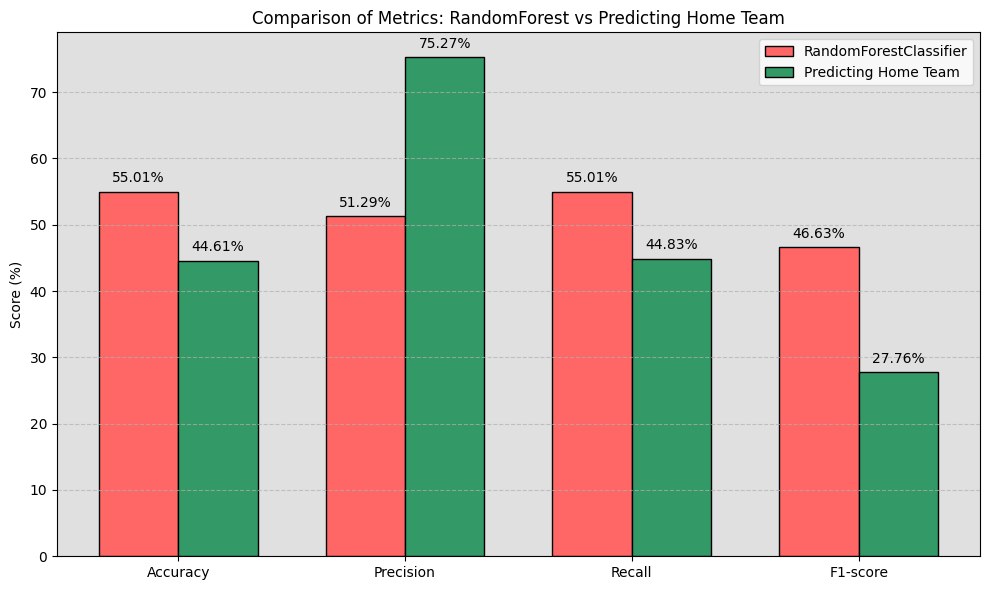

In [19]:
# Calculations for RandomForestClassifier

accuracy = accuracy_score(y_test, predictions)
precision_rf = precision_score(y_test, predictions, average='weighted')
recall_rf = recall_score(y_test, predictions, average='weighted')
f1_rf = f1_score(y_test, predictions, average='weighted')

# Calculations for Home Team Win stratedy

home_predictions = ['Home win'] * len(y_test)
precision_home = precision_score(y_test, home_predictions, average='weighted', zero_division=1)
recall_home = recall_score(y_test, home_predictions, average='weighted', zero_division=1)
f1_home = f1_score(y_test, home_predictions, average='weighted', zero_division=1)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

rf_scores = [accuracy, precision_rf, recall_rf, f1_rf]
home_scores = [
    len(df[df['result'] == 'Home win']) / len(df),
    precision_home,
    recall_home,
    f1_home
]

colors = ['#ff6666', '#339966']
bar_width = 0.35
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
bars_rf = ax.bar(x - bar_width/2, [score * 100 for score in rf_scores], bar_width, label='RandomForestClassifier', color=colors[0], edgecolor='black')
bars_home = ax.bar(x + bar_width/2, [score * 100 for score in home_scores], bar_width, label='Predicting Home Team', color=colors[1], edgecolor='black')

# Adding values to the ends of the bars

for bar in bars_rf:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')
    
for bar in bars_home:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score (%)')
ax.set_title('Comparison of Metrics: RandomForest vs Predicting Home Team')
ax.legend()
ax.set_facecolor('#e0e0e0')

plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()